In [1]:
# Standard packages
import numpy as np
import matplotlib.pyplot as plt
import cv2
from os.path import join
import os
import glob
import json
import sys

# Progress bar
from tqdm import tqdm

# Torch core
import torch
print("Torch version:", torch.__version__)
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch.nn.functional import relu
from torch import optim
import torch.nn.functional as F

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# DeepLabV3 and other segmentation models
import segmentation_models_pytorch as smp

# (Optional) Set up matplotlib display for Jupyter
%matplotlib inline
import matplotlib.pylab as pt

Torch version: 2.7.0+cu126


# Initial investigation of the dataset

In [2]:
root_path = 'a2d2-dataset/camera_lidar_semantic'
# get the list of files in lidar directory
file_names = sorted(glob.glob(join(root_path, '*/camera/cam_front_center/*.png')))

# select the lidar point cloud
test_file_name = file_names[5]

In [3]:
test_file_name

'a2d2-dataset/camera_lidar_semantic/20180807_145028/camera/cam_front_center/20180807145028_camera_frontcenter_000000544.png'

In [4]:
len(file_names)

31448

In [5]:
def extract_image_file_name(file_name):
    file_name_image = file_name.split('/')
    file_name_image = file_name_image[-1].split('.')[0]
    file_name_image = file_name_image.split('_')
    file_name_image = file_name_image[0] + '_' + \
                        'camera_' + \
                        file_name_image[2] + '_' + \
                        file_name_image[3] + '.png'

    return file_name_image

In [6]:
seq_name = test_file_name.split('/')[2]
print('Seq name: ', seq_name)
file_name_image = extract_image_file_name(test_file_name)
print('File name image: ', file_name_image)
file_name_image = join(root_path, seq_name, 'camera/cam_front_center/', file_name_image)
print('Full image file name: ', file_name_image)
image_front_center = cv2.imread(file_name_image)

Seq name:  20180807_145028
File name image:  20180807145028_camera_frontcenter_000000544.png
Full image file name:  a2d2-dataset/camera_lidar_semantic/20180807_145028/camera/cam_front_center/20180807145028_camera_frontcenter_000000544.png


In [7]:
image_front_center = cv2.cvtColor(image_front_center, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'front center')

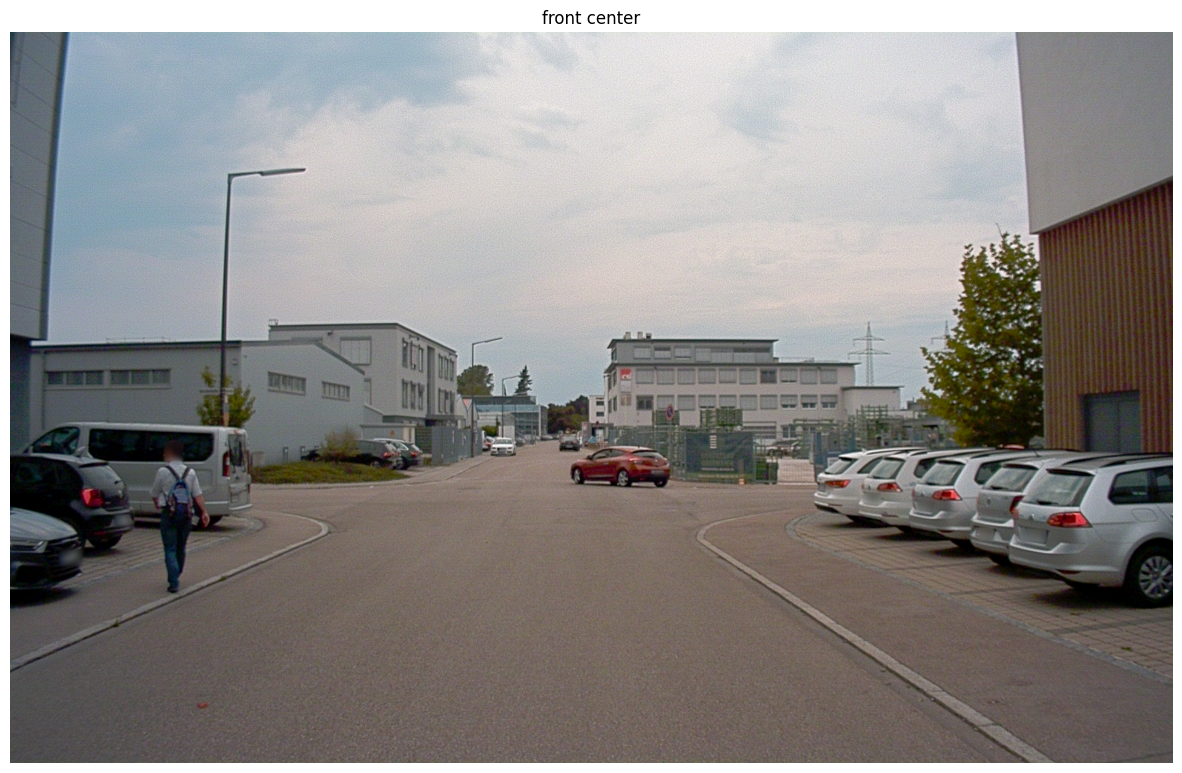

In [8]:
pt.fig = pt.figure(figsize=(15, 15))

# display image from front center camera
pt.imshow(image_front_center)
pt.axis('off')
pt.title('front center')

In [9]:
def extract_semantic_file_name_from_image_file_name(file_name_image):
    file_name_semantic_label = file_name_image.split('/')
    file_name_semantic_label = file_name_semantic_label[-1].split('.')[0]
    file_name_semantic_label = file_name_semantic_label.split('_')
    file_name_semantic_label = file_name_semantic_label[0] + '_' + \
                  'label_' + \
                  file_name_semantic_label[2] + '_' + \
                  file_name_semantic_label[3] + '.png'
    
    return file_name_semantic_label

In [10]:
seq_name = test_file_name.split('/')[2]
print('Seq: ', seq_name)
file_name_semantic_label = extract_semantic_file_name_from_image_file_name(file_name_image)
print('Semantic label file name: ', file_name_semantic_label)
file_name_semantic_label = join(root_path, seq_name, 'label/cam_front_center/', file_name_semantic_label)
print('Full semantic label file path: ', file_name_semantic_label)
semantic_image_front_center = cv2.imread(file_name_semantic_label)

Seq:  20180807_145028
Semantic label file name:  20180807145028_label_frontcenter_000000544.png
Full semantic label file path:  a2d2-dataset/camera_lidar_semantic/20180807_145028/label/cam_front_center/20180807145028_label_frontcenter_000000544.png


In [11]:
semantic_image_front_center = cv2.cvtColor(semantic_image_front_center, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'label front center')

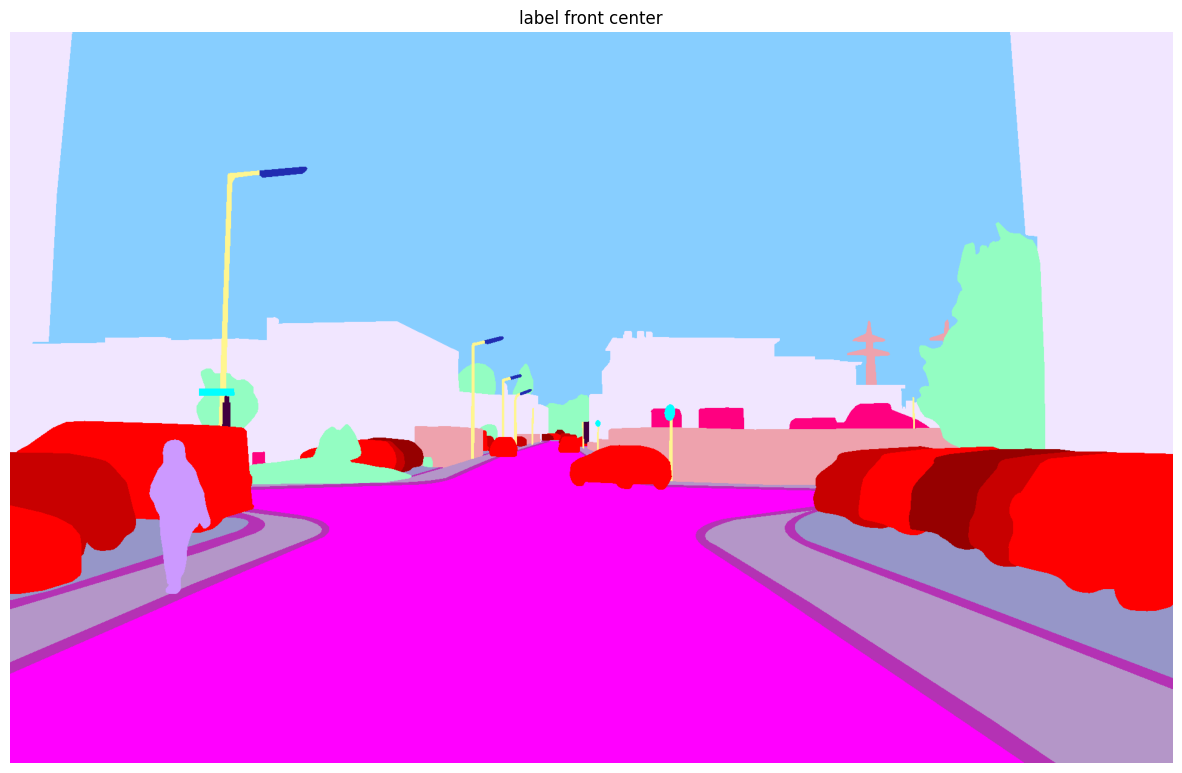

In [12]:
pt.fig = pt.figure(figsize=(15, 15))
pt.imshow(semantic_image_front_center)
pt.axis('off')
pt.title('label front center')

In [13]:
with open('a2d2-dataset/camera_lidar_semantic/class_list.json', 'r') as f:
    classes = json.load(f)

In [14]:
classes

{'#ff0000': 'Car 1',
 '#c80000': 'Car 2',
 '#960000': 'Car 3',
 '#800000': 'Car 4',
 '#b65906': 'Bicycle 1',
 '#963204': 'Bicycle 2',
 '#5a1e01': 'Bicycle 3',
 '#5a1e1e': 'Bicycle 4',
 '#cc99ff': 'Pedestrian 1',
 '#bd499b': 'Pedestrian 2',
 '#ef59bf': 'Pedestrian 3',
 '#ff8000': 'Truck 1',
 '#c88000': 'Truck 2',
 '#968000': 'Truck 3',
 '#00ff00': 'Small vehicles 1',
 '#00c800': 'Small vehicles 2',
 '#009600': 'Small vehicles 3',
 '#0080ff': 'Traffic signal 1',
 '#1e1c9e': 'Traffic signal 2',
 '#3c1c64': 'Traffic signal 3',
 '#00ffff': 'Traffic sign 1',
 '#1edcdc': 'Traffic sign 2',
 '#3c9dc7': 'Traffic sign 3',
 '#ffff00': 'Utility vehicle 1',
 '#ffffc8': 'Utility vehicle 2',
 '#e96400': 'Sidebars',
 '#6e6e00': 'Speed bumper',
 '#808000': 'Curbstone',
 '#ffc125': 'Solid line',
 '#400040': 'Irrelevant signs',
 '#b97a57': 'Road blocks',
 '#000064': 'Tractor',
 '#8b636c': 'Non-drivable street',
 '#d23273': 'Zebra crossing',
 '#ff0080': 'Obstacles / trash',
 '#fff68f': 'Poles',
 '#960096':

In [15]:
np.unique(semantic_image_front_center)

array([  0,  33,  44,  50,  64, 128, 135, 143, 147, 150, 153, 162, 173,
       177, 180, 194, 200, 204, 206, 230, 238, 241, 246, 253, 255],
      dtype=uint8)

In [16]:
semantic_image_front_center.shape

(1208, 1920, 3)

In [17]:
image_front_center.shape

(1208, 1920, 3)

# Create a dataset with images and corresponding masks

In [18]:
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

In [19]:
COLOR_TO_CLASS = {}
for idx, (hex_color, class_name) in enumerate(classes.items()):
    rgb = hex_to_rgb(hex_color)
    COLOR_TO_CLASS[idx] = rgb

In [20]:
len(COLOR_TO_CLASS)

55

In [21]:
def rgb_to_class(mask_rgb, color_to_class):
    h, w, _ = mask_rgb.shape
    class_mask = np.zeros((h, w), dtype=np.uint8)
    color_to_id = {v: k for k, v in color_to_class.items()}
    mask_flat = mask_rgb.reshape(-1, 3)
    class_mask_flat = np.zeros(mask_flat.shape[0], dtype=np.uint8)
    for color, class_id in color_to_id.items():
        matches = np.all(mask_flat == color, axis=1)
        class_mask_flat[matches] = class_id
    return class_mask_flat.reshape(h, w)

In [22]:
class SemanticSegmentationDataset(Dataset):
    def __init__(self, file_names, root_path, transform=None, patch_size=None, random_crop=True):
        self.file_names = file_names
        self.root_path = root_path
        self.transform = transform
        self.patch_size = patch_size
        self.random_crop = random_crop

    def extract_image_file_name(self, file_name):
        file_name_image = file_name.split('/')
        file_name_image = file_name_image[-1].split('.')[0]
        file_name_image = file_name_image.split('_')
        file_name_image = file_name_image[0] + '_' + \
                        'camera_' + \
                        file_name_image[2] + '_' + \
                        file_name_image[3] + '.png'

        return file_name_image

    def extract_semantic_file_name_from_image_file_name(self, file_name_image):
        file_name_semantic_label = file_name_image.split('/')
        file_name_semantic_label = file_name_semantic_label[-1].split('.')[0]
        file_name_semantic_label = file_name_semantic_label.split('_')
        file_name_semantic_label = file_name_semantic_label[0] + '_' + \
                  'label_' + \
                  file_name_semantic_label[2] + '_' + \
                  file_name_semantic_label[3] + '.png'
    
        return file_name_semantic_label

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        
        seq_name = file_name.split('/')[2]
        
        # Image path
        file_name_image = self.extract_image_file_name(file_name)
        file_name_image = join(self.root_path, seq_name, 'camera/cam_front_center', file_name_image)
        image_front_center = cv2.imread(file_name_image)
        image_front_center = cv2.cvtColor(image_front_center, cv2.COLOR_BGR2RGB)

        # Semantic mask path
        file_name_semantic_label = self.extract_semantic_file_name_from_image_file_name(file_name_image)
        file_name_semantic_label = join(self.root_path, seq_name, 'label/cam_front_center', os.path.basename(file_name_semantic_label))
        semantic_image_front_center = cv2.imread(file_name_semantic_label)
        semantic_image_front_center = cv2.cvtColor(semantic_image_front_center, cv2.COLOR_BGR2RGB)
        
        mask = rgb_to_class(semantic_image_front_center, COLOR_TO_CLASS)
        
        # Normalize image
        image_front_center = image_front_center.astype(np.float32) / 255.0
        
        if self.patch_size is not None:
            h, w, _ = image_front_center.shape
            ph, pw = self.patch_size

            if h < ph or w < pw:
                raise ValueError(f"Patch size {self.patch_size} is too big for image of size ({h}, {w})")

            if self.random_crop:
                top = np.random.randint(0, h - ph + 1)
                left = np.random.randint(0, w - pw + 1)
            else:
                top = (h - ph) // 2
                left = (w - pw) // 2

            image_front_center = image_front_center[top:top+ph, left:left+pw, :]
            mask = mask[top:top+ph, left:left+pw]

        if self.transform:
            augmented = self.transform(image=image_front_center, mask=mask)
            image_front_center = augmented['image']
            mask = augmented['mask']

        # Convert to torch tensors
        image_tensor = torch.tensor(image_front_center.transpose(2, 0, 1), dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.long)

        return image_tensor, mask_tensor

# Functions for visualizing

In [23]:
def plot_full_image_and_mask(dataset, idx=0):
    image_tensor, mask_tensor = dataset[idx]
    
    # Convert image and mask to numpy for plotting
    image_np = image_tensor.permute(1, 2, 0).numpy()
    mask_np = mask_tensor.numpy()

    # Plot
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Full Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap="nipy_spectral")
    plt.title("Semantic Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [24]:
def plot_patch_image_and_mask(dataset, num_samples=4):
    plt.figure(figsize=(12, 3 * num_samples))
    
    for i in range(num_samples):
        image_tensor, mask_tensor = dataset[i]
        
        # Convert tensors to NumPy arrays for plotting
        image_np = image_tensor.permute(1, 2, 0).numpy()
        mask_np = mask_tensor.numpy()

        # Plot image
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(image_np)
        plt.title(f'Image Patch {i}')
        plt.axis('off')

        # Plot mask
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(mask_np, cmap='nipy_spectral')
        plt.title(f'Mask Patch {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [25]:
def visualize_predictions_and_ground_truth(model, dataloader, device, num_samples=5):
    model = model.to(device)
    model.eval()
    count = 0

    with torch.no_grad():
        for img, mask in dataloader:
            img = img.to(device)
            mask = mask.to(device)
            output = model(img)
            pred = torch.argmax(output, dim=1)  # shape: [B, H, W]

            batch_size = img.size(0)
            for i in range(batch_size):
                if count >= num_samples:
                    return  # stop after visualizing num_samples

                img_sample = img[i].cpu().numpy().transpose(1, 2, 0)
                true_mask_sample = mask[i].cpu().numpy()
                pred_mask_sample = pred[i].cpu().numpy()
                print('Unique classes in ground truth:', np.unique(true_mask_sample))
                print('Unique classes in prediction:', np.unique(pred_mask_sample))
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(img_sample)
                ax[0].set_title("Image")
                ax[1].imshow(true_mask_sample)
                ax[1].set_title("Ground Truth")
                ax[2].imshow(pred_mask_sample)
                ax[2].set_title("Prediction")

                plt.show()
                count += 1

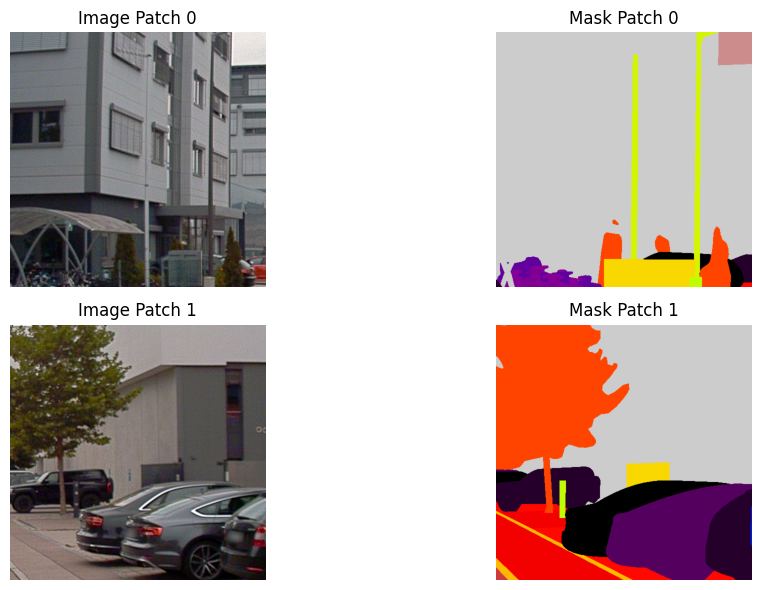

In [26]:
patch_dataset = SemanticSegmentationDataset(file_names=file_names[:2], root_path=root_path, transform=None, patch_size=(512,512))

plot_patch_image_and_mask(patch_dataset, num_samples=2)

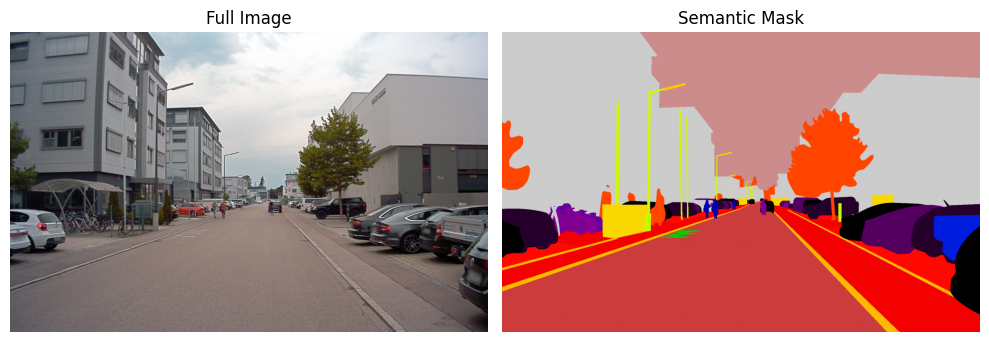

In [27]:
full_dataset = SemanticSegmentationDataset(file_names=file_names[:2], root_path=root_path, transform=None, random_crop=False)
plot_full_image_and_mask(full_dataset)

# Finetuning

## Train/test split

In [28]:
file_names = file_names[:200]
dataset = SemanticSegmentationDataset(file_names=file_names, root_path=root_path, transform=None, patch_size=(256,256))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
print("Train dataset size: ", len(train_dataset))
print("Test dataset size: ", len(test_dataset))

Train dataset size:  160
Test dataset size:  40


In [30]:
def compute_metrics(y_pred, y_true, num_classes=4):
    y_pred_flat = y_pred.view(-1).cpu().numpy()
    y_true_flat = y_true.view(-1).cpu().numpy()

    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    
    iou_per_class = jaccard_score(y_true_flat, y_pred_flat, average=None, labels=list(range(num_classes)))
    mean_iou = np.mean(iou_per_class)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "iou_per_class": iou_per_class.tolist()
    }

# DeepLabv3

In [31]:
model = smp.DeepLabV3(
    encoder_name="resnet34",           # you can try 'mobilenet_v2' later
    encoder_weights="imagenet",        # use pretrained encoder
    in_channels=3,                     # RGB
    classes=len(COLOR_TO_CLASS),           
    decoder_use_batchnorm=True
)

In [32]:
for param in model.encoder.parameters():
    param.requires_grad = False 

In [33]:
optimizer = optim.AdamW(model.parameters(), lr=0.005)

device = "cuda" if torch.cuda.is_available() else "cpu"

#criterion = nn.CrossEntropyLoss().to(device)
criterion = smp.losses.DiceLoss(mode='multiclass', classes=list(COLOR_TO_CLASS.keys()), from_logits=True)

In [34]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

## To load from checkpoint

In [35]:
checkpoint_path = 'checkpoint_unet_finetune.pth'
start_epoch = 0
train_losses = []
val_losses = []

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint '{checkpoint_path}'...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
    start_epoch = checkpoint['epoch'] + 1  # resume from next epoch
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_accuracies = checkpoint.get('val_accuracies', [])
    criterion = smp.losses.DiceLoss(mode='multiclass', classes=list(COLOR_TO_CLASS.keys()), from_logits=True)
    print(f"Resuming training from epoch {start_epoch}...")
else:
    print("No checkpoint found, training from scratch.")

Loading checkpoint 'checkpoint_unet_finetune.pth'...
Resuming training from epoch 9...


## Training

In [36]:
best_val_loss = float('inf')
patience = 10  # number of epochs to wait for improvement
trigger_times = 0
early_stop = False

model = model.to(device)
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    model.train()
    train_running_loss = 0
    train_running_dc = 0
    all_train_preds = []
    all_train_targets = []

    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].to(device)
        y_pred = model(img)
        loss = criterion(y_pred, mask)
        optimizer.zero_grad()

        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.argmax(y_pred, dim=1)   # shape: [B, H, W]
        all_train_preds.append(pred)
        all_train_targets.append(mask)

    y_train_pred_all = torch.cat(all_train_preds)
    
    y_train_true_all = torch.cat(all_train_targets)
    train_metrics = compute_metrics(y_train_pred_all, y_train_true_all, num_classes=len(COLOR_TO_CLASS))
    train_loss = train_running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_accuracies.append(train_metrics['accuracy'])
    # -------- VALIDATION --------
    model.eval()
    val_running_loss = 0
    all_val_preds = []
    all_val_targets = []

    with torch.no_grad():
        for idx, (img, mask) in enumerate(test_dataloader):
            img = img.to(device)
            mask = mask.to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            val_running_loss += loss.item()

            pred = torch.argmax(y_pred, dim=1)
            all_val_preds.append(pred)
            all_val_targets.append(mask)

    # Val metrics
    y_val_pred_all = torch.cat(all_val_preds)
    y_val_true_all = torch.cat(all_val_targets)
    val_metrics = compute_metrics(y_val_pred_all, y_val_true_all, num_classes=y_pred.shape[1])
    val_loss = val_running_loss / len(test_dataloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_metrics['accuracy'])
    # -------- LOG --------
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Accuracy:  {train_metrics['accuracy']:.4f} | Val Accuracy:  {val_metrics['accuracy']:.4f}")
    print("-" * 40)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }, 'checkpoint_unet_finetune.pth')
    # -------- EARLY STOPPING --------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        # Optional: save model if it's the best
        torch.save(model.state_dict(), "best_model_unet_finetune.pth")
        
    else:
        trigger_times += 1
        print(f"EarlyStopping counter: {trigger_times} / {patience}")
        if trigger_times >= patience:
            print("Early stopping triggered.")
            early_stop = True
            break

100%|██████████| 5/5 [08:25<00:00, 101.19s/it]
/scratch/lustre/home/luiv1222/miniconda3/envs/deeplab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/lustre/home/luiv1222/miniconda3/envs/deeplab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 10/10
Train Loss: 0.3960 | Val Loss: 0.2700
Train Accuracy:  0.7719 | Val Accuracy:  0.7509
----------------------------------------


## Plot loss and accuracy curves

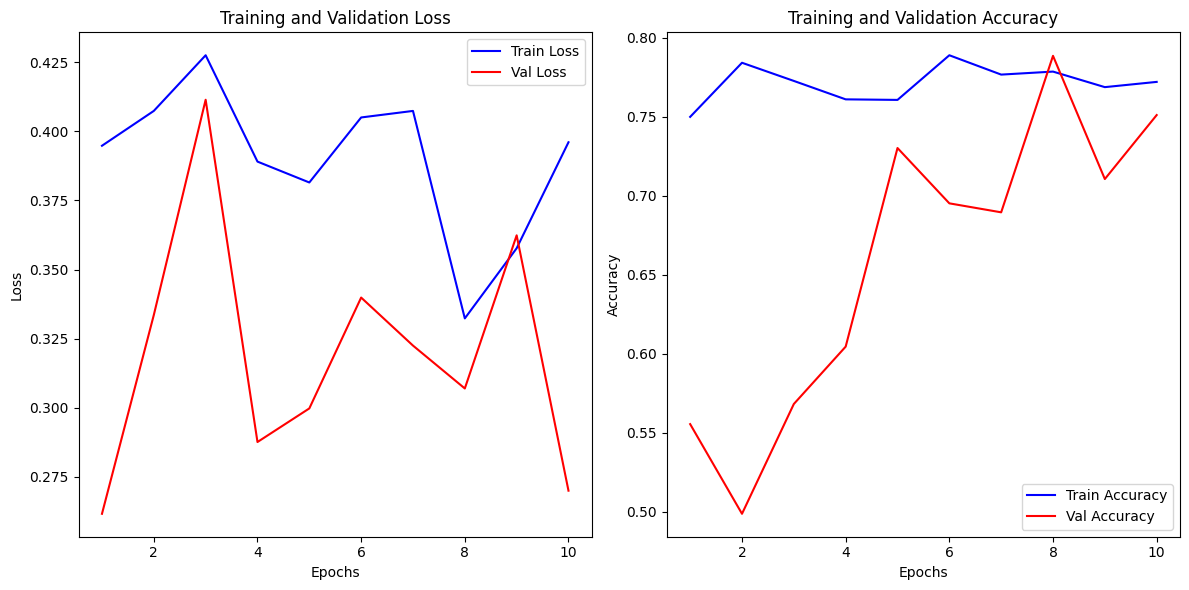

In [39]:
epochs = range(1, 11)

# Plot Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Val Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate

In [40]:
def evaluate(y_pred, y_true, num_classes=4):
    # Flatten predictions and ground truths
    y_pred_flat = y_pred.view(-1).cpu().numpy()
    y_true_flat = y_true.view(-1).cpu().numpy()

    # Pixel Accuracy: percentage of correctly predicted pixels
    pixel_accuracy = np.mean(y_pred_flat == y_true_flat)

    # Other classification metrics
    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)

    # IoU per class and mean IoU
    iou_per_class = jaccard_score(y_true_flat, y_pred_flat, average=None, labels=list(range(num_classes)))
    mean_iou = np.mean(iou_per_class)

    return {
        "pixel_accuracy": pixel_accuracy,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "iou_per_class": iou_per_class.tolist(),
        "mean_iou": mean_iou
    }

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
state_dict = torch.load('best_model_unet_finetune.pth' , map_location=device)
model = smp.Unet(
    encoder_name="resnet34",    # choose encoder
    encoder_weights="imagenet", # use ImageNet pre-trained weights
    in_channels=3,              # RGB
    classes=len(COLOR_TO_CLASS)                   # binary segmentation
)
model.load_state_dict(state_dict)
model = model.to(device)

/tmp/slurm-ivab7329-176132/ipykernel_780373/706858395.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('best_model_unet_finetune.pth' , map_locati

In [41]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks in test_dataloader:  # Adjust variable names based on your DataLoader
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        
        # Convert logits to predicted class labels
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds)
        all_targets.append(masks)

# Concatenate all batches
y_pred = torch.cat(all_preds, dim=0)
y_true = torch.cat(all_targets, dim=0)

# Compute metrics
metrics = compute_metrics(y_pred, y_true, num_classes=len(COLOR_TO_CLASS))

# Print results
for key, value in metrics.items():
    print(f"{key}: {value}")

accuracy: 0.7045791625976563
precision: 0.1906854064064815
recall: 0.19749496607935246
f1: 0.1657318640781637
iou_per_class: [0.44017094017094016, 0.020047520047520046, 0.007475190101817244, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0111467288357861, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018855410270987305, 0.0, 0.0, 0.15458774354479876, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12072680571741147, 0.09093921919533374, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.034528210411490214, 0.0, 0.0, 0.05413297724037742, 0.0, 0.006062056313312594, 0.0, 0.0, 0.7549014672941887, 0.0, 0.19876033873546656, 0.0, 0.0, 0.0, 0.023954139084146592, 0.7091706627304202, 0.8873535788491071, 0.5855367446579164, 0.0, 0.0]


/scratch/lustre/home/luiv1222/miniconda3/envs/deeplab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Unique classes in ground truth: [29 35 38 43 51 52]
Unique classes in prediction: [43 51 52]


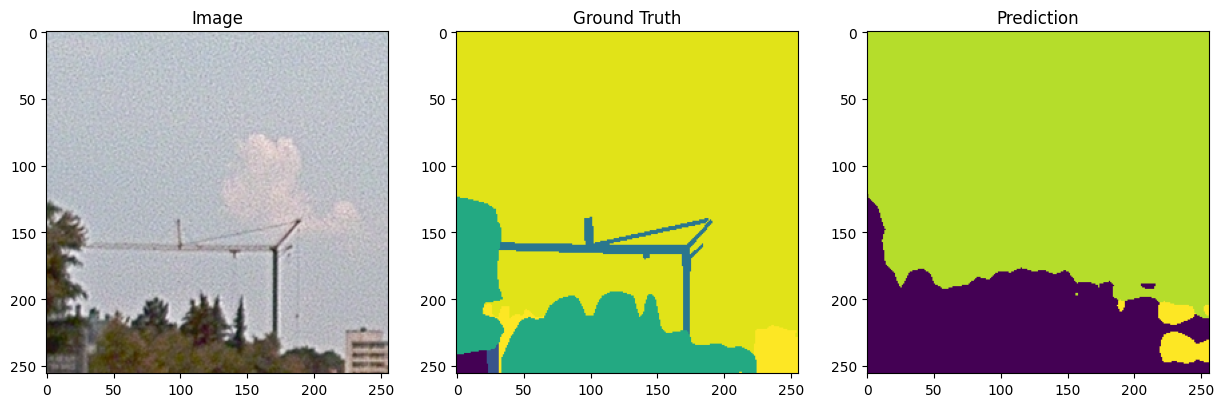

Unique classes in ground truth: [ 0 27 29 34 35 39 40 43 45 49 50 52]
Unique classes in prediction: [ 0  1  2 11 17 20 27 29 34 35 38 40 43 45 49 50 52]


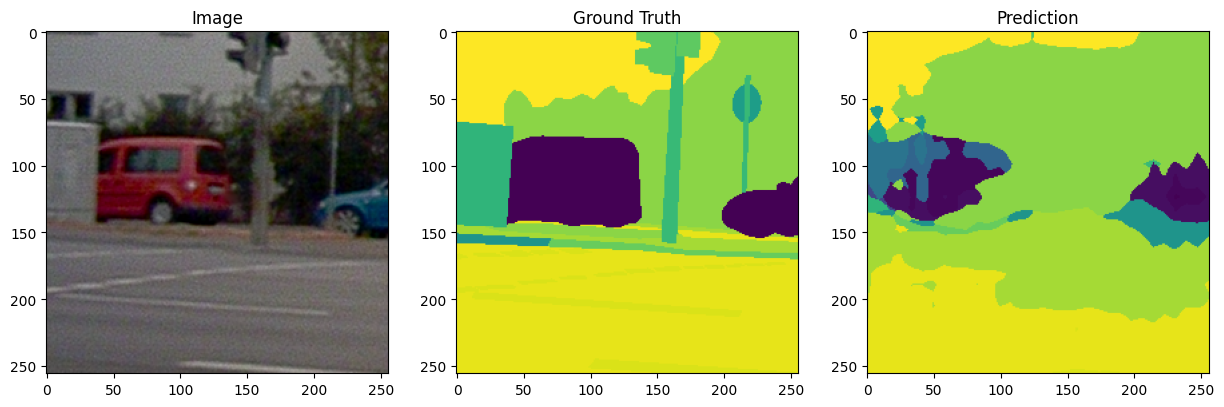

Unique classes in ground truth: [27 32 43 45 50]
Unique classes in prediction: [27 40 43 45]


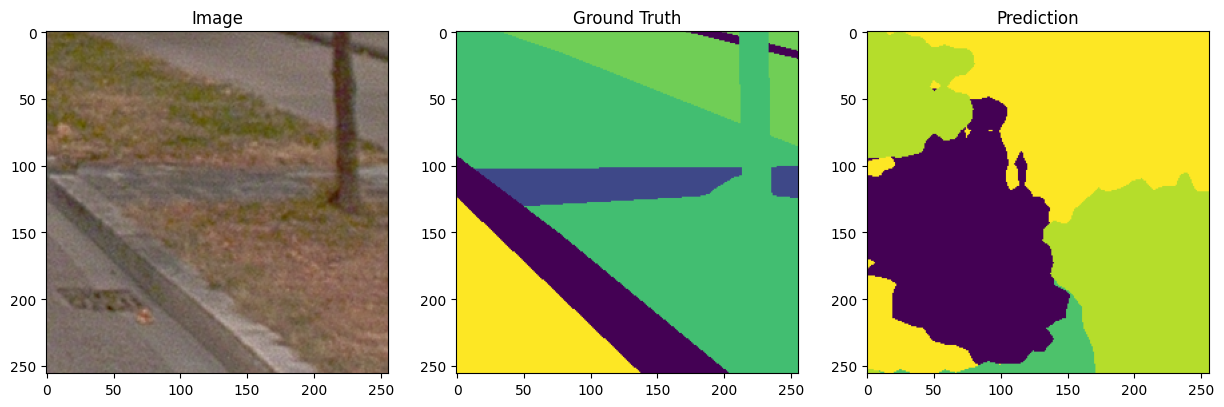

Unique classes in ground truth: [27 32 40 45 49 50]
Unique classes in prediction: [27 28 40 49 50]


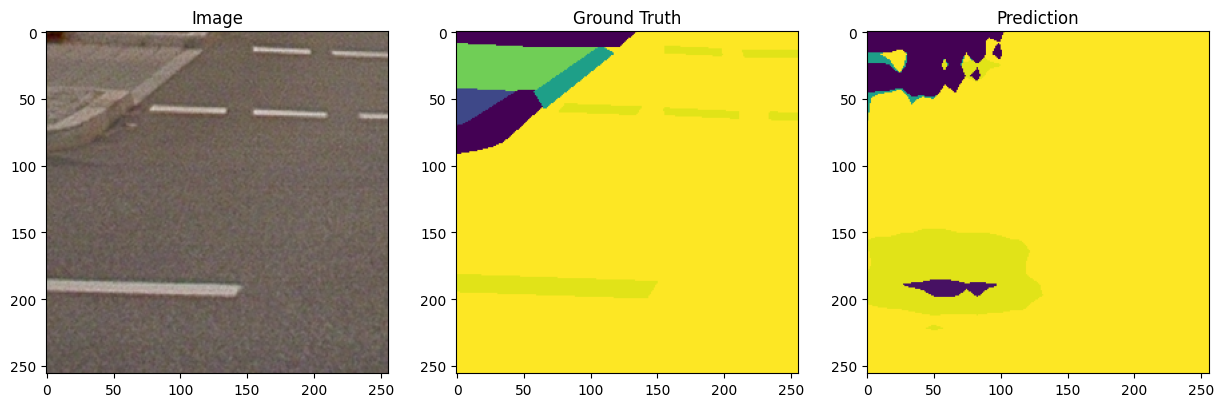

Unique classes in ground truth: [38 51]
Unique classes in prediction: [11 27 34 35 45 51]


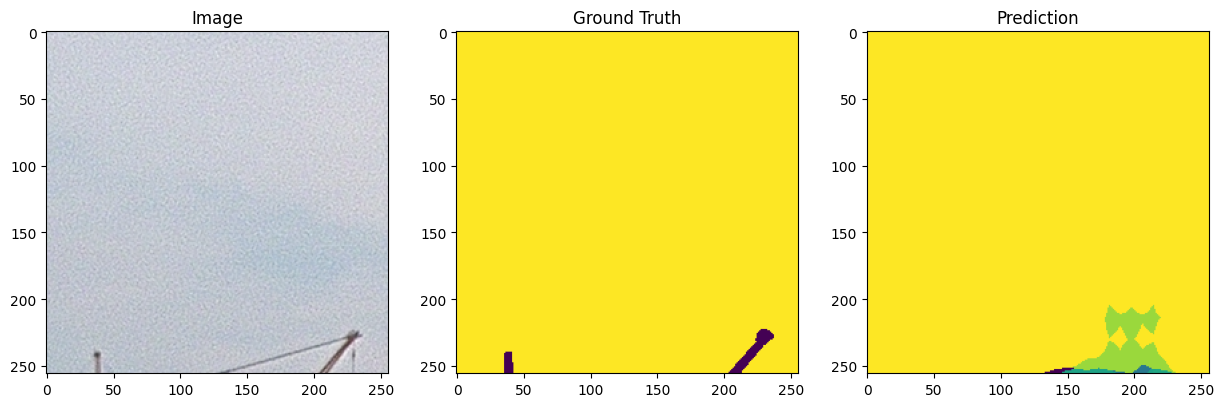

In [42]:
visualize_predictions_and_ground_truth(model, test_dataloader, device, num_samples=5)